In [2]:
!pip install python-graphblas[default]
!pip install metagraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 4.3 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from metagraph import concrete_algorithm, NodeID
from metagraph.plugins import has_grblas
from metagraph.plugins.core import exceptions
from typing import Tuple, Iterable, Any, Union, Optional


from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector, Scalar
from graphblas.io import mmread

## Create and visualize a Matrix

In [14]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]
rows, cols, weights = data
A = Matrix.from_coo(rows, cols, weights)
A
# Size of the sparse matrix is 7x7 with 12 non-zero elements of type INT64

"M_1"      nvals  nrows  ncols  dtype   format
gb.Matrix     12      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

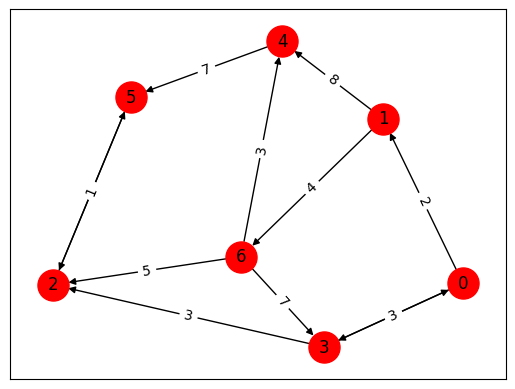

In [15]:
gb.viz.draw(A)

## Single-source Shortest Path

This uses the **_min-plus_** semiring because we want to add the edges, then take the minimum length of available paths.

In [16]:
# Create a vector and initialize a starting vertex (1) with a distance of zero
v = Vector(A.dtype, A.nrows)
v[1] << 0
v

"v_2"      nvals  size  dtype        format
gb.Vector      1     7  INT64  bitmap (iso)
-------------------------------------------
index 0  1 2 3 4 5 6
value    0

In [17]:
A

"M_1"      nvals  nrows  ncols  dtype   format
gb.Matrix     12      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

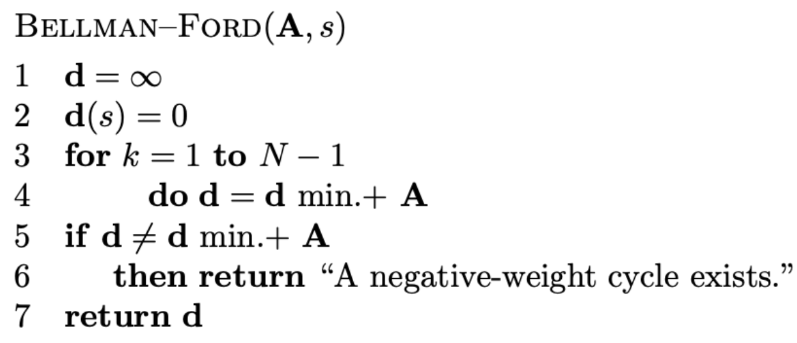

In [37]:
def bellman_ford(A, vertice):
  v = Vector(A.dtype, A.nrows)
  v[vertice] << 0
  w = v.dup()
  while True:
      w_old = w.dup()
      w(binary.min) << w.vxm(A, semiring.min_plus)
      if w.isequal(w_old):
          break
  w=[w.get(i, default='-inf') for i in range(A.nrows)]
  return w
bellman_ford(A, 1)

[14, 0, 9, 11, 7, 10, 4]

In [41]:
def multi_source_bellman_ford(A, vertices):
  N = A.nrows
  output = []
  for vertex in vertices:
      v = Vector(A.dtype, A.nrows)
      v[vertex] << 0
      w = v.dup()
      while True:
        w_old = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_old):
          break
      output.append((vertex, [w.get(i, default=float('inf')) for i in range(N)]))
  return output
bellman_ford(A, [1,5])

[14, 0, 1, 11, 7, 0, 4]

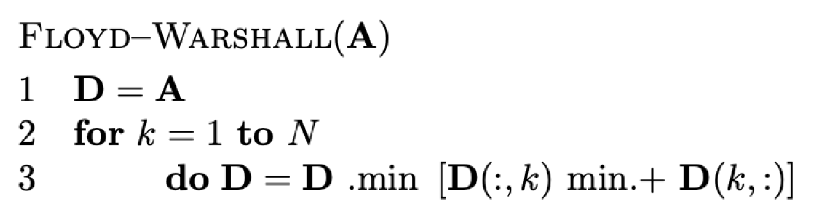

In [71]:
import graphblas as gb
import numpy as np

def floyd_warshall(graph: gb.Matrix) -> gb.Matrix:
    n = graph.nrows
    dist = graph.dup()

    for i in range(n):
        dist[i, i] = 0

    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i, j] = min(dist[i, j], dist[i, k] + dist[k, j])
    result = []

    for i in range(1, graph.nrows-1):
      distances = [dist.get(i, j, default=float('-inf')) for j in range(graph.ncols)]
      result.append((i, distances))
    return result

print(floyd_warshall(A))

[(1, [-inf, 0, -inf, -inf, 7, -inf, 4]), (2, [-inf, -inf, 0, -inf, -inf, 1, -inf]), (3, [3, -inf, 1, 0, -inf, -inf, -inf]), (4, [-inf, -inf, -inf, -inf, 0, 1, -inf]), (5, [-inf, -inf, 1, -inf, -inf, 0, -inf])]


In [79]:
import graphblas as gb
import numpy as np

def all_pairs_shortest_paths(graph):
    num_vertices = graph.nrows

    dist = graph.dup()

    for i in range(num_vertices):
        dist[i, i] = 0

    for k in range(num_vertices):
        for i in range(num_vertices):
            for j in range(num_vertices):
                dist[i, j] << min(dist[i, j], dist[i, k] + dist[k, j])

    result = []
    for i in range(1, graph.nrows-1):
      distances = [dist.get(i, j, default=float('-inf')) for j in range(graph.ncols)]
      result.append((i, distances))

    return result

def transitive_closure(graph):
    num_vertices = graph.nrows

    closure = graph.dup()

    for i in range(num_vertices):
        closure[i, i] = 1

    for k in range(num_vertices):
        for i in range(num_vertices):
            for j in range(num_vertices):
                closure[i, j] = closure[i, j] or (closure[i, k] and closure[k, j])

    return closure


shortest_paths = all_pairs_shortest_paths(A)
print("Shortest paths:", shortest_paths)

closure = transitive_closure(A)
print("Transitive closure:")
with np.printoptions(precision=2, suppress=True):
    print(closure)

Shortest paths: [(1, [-inf, 0, -inf, -inf, 7, -inf, 4]), (2, [-inf, -inf, 0, -inf, -inf, 1, -inf]), (3, [3, -inf, 1, 0, -inf, -inf, -inf]), (4, [-inf, -inf, -inf, -inf, 0, 1, -inf]), (5, [-inf, -inf, 1, -inf, -inf, 0, -inf])]
Transitive closure:
"M_43"     nvals  nrows  ncols  dtype   format
gb.Matrix     35      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0  1  2  3  3  8  1  4
1  3  1  1  7  8  7  4
2        1        1   
3  3  2  3  1  8  1  4
4        1     1  7   
5        1        1   
6  3  2  5  7  3  1  1
